# Day 12-preparing kanban for Amazon Rainforest project

#### Goal: Identify rivers in the Amazon Rainforest from Sentinel-2 satellite images

#### Here are the main steps I will go through:

1. Look at the big picture. First, you need to frame the problem: is it supervised, unsupervised, or Reinforcement Learning? Is it a classification task, a regression task, or something else? Should you use batch learning or online learning techniques? 


2. Get the data. Get Sentinel-2 data over the Amazon Rainforest for the dry season (Aug-Nov). Get the benchmark data of the Amazon Rainforest rivers. 


3. Discover and visualize the data to gain insights. Check for cloud and image processing required.


4. Prepare the data for Machine Learning algorithms.


5. Select a model and train it. 


6. Fine-tune your model. Check the output against a benchmark to see how good the classification of Amazon River systems is.


7. Present your solution. If the solution needs more work or another machine learning teachnique, go back to the beginning/iterate until a solution is found.


8. Launch, monitor, and maintain your system.

Some sources I am learning from:
- https://www.youtube.com/watch?v=QbgIwOq7ksQ - video demo using senitnel imagery, interactive visualisation with leaflet, resnet50 for cloud free imagery, unet for tulip field classification.  
- https://gisgeography.com/image-classification-techniques-remote-sensing/ - types of image classification of satellite imagery: unsupervised, supervised, OBIA. 
- https://towardsdatascience.com/data-science-and-satellite-imagery-985229e1cd2f - some great links and using machine learning to detect ships; k-means to cluster ship/not-ship and then a CNN to classify the possible ship chips. Really cool! They recommend, numpy, scikit-learn (and image), opencv, keras, tensorflow. 


### 1. Big picture
**First** try unsupervised classfication: clustering techniques e.g. k-means, hierarchical clustering, DBSCAN ((Density-Based Spatial Clustering of Applications with Noise)

K-means is a clustering algorithm that tries to partition a set of points into K sets (clusters) such that the points in each cluster tend to be near each other. It is unsupervised because the points have no external classification.

Sources: 
- https://towardsdatascience.com/unsupervised-learning-with-python-173c51dc7f03 - by Vihar Kurama
- https://medium.com/@h4k1m0u/clustering-a-satellite-image-with-scikit-learn-14adb2ca3790 - tutorial on clustering satellite imagery with gdal and scikit-learn cluster
- https://dzone.com/articles/cluster-image-with-k-means another tutorial on k-means

**Second** try supervised classification: k-nearest neighbour, naive bayes, decision trees, support vector machines. 

[K-nn with python](https://scikit-learn.org/stable/modules/neighbors.html) with scikit learn.  

K-nearest neighbors is a classification (or regression) algorithm that in order to determine the classification of a point, combines the classification of the K nearest points. It is supervised because you are trying to classify a point based on the known classification of other points.

Interesting: [OBIA Object based image analysis](https://gisgeography.com/nearest-neighbor-classification-guide-ecognition/) 


**Third** try supervised classification: deep learning e.g.u-net


In [78]:
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import cluster
import rasterio
from rasterio.plot import show
import numpy as np
from affine import Affine

In [43]:
path = Path('../data/rivers_amazon_data/')
image_path = path.joinpath('T21MYS_20180721T140051_TCI.jp2')
out_tif = path.joinpath('clustered_10_test.tif')

In [79]:
with rasterio.open(image_path) as src:
    image = src.read()
    meta = src.meta

In [53]:
print(meta)
image.shape

{'driver': 'JP2OpenJPEG', 'dtype': 'uint8', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS.from_dict(init='epsg:32721'), 'transform': Affine(10.0, 0.0, 699960.0,
       0.0, -10.0, 9700000.0)}


(3, 10980, 10980)

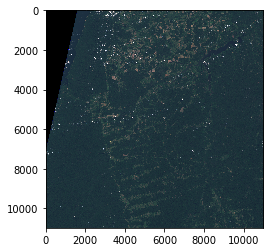

In [15]:
show(image);

Zoom in and extract band interested in classifying

In [33]:
image_chip = image[:1, 1500:4000, 7000:9500]

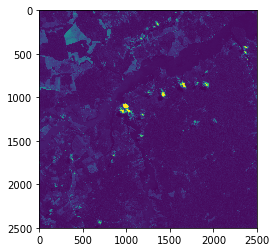

In [34]:
show(image_chip);

In [35]:
image_chip.shape

(1, 2500, 2500)

In [36]:
X = image_chip.reshape((-1,1))

In [38]:
X.shape

(6250000, 1)

In [42]:
k_means = cluster.KMeans(n_clusters=10)
_ = k_means.fit(X)

In [44]:
X_clustered = k_means.labels_
X_clustered = X_clustered.reshape(image_chip.shape)

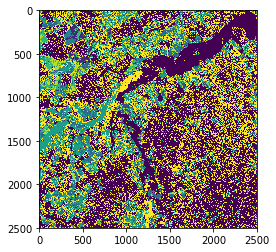

In [45]:
show(X_clustered);

In [101]:
aff = meta['transform']
newaff = Affine(aff.a, aff.b, aff.c + 7000,
                aff.d, aff.e, aff.f + 1500); newaff

Affine(10.0, 0.0, 706960.0,
       0.0, -10.0, 9701500.0)

In [102]:
out_meta = meta.copy()
out_meta.update({'driver': 'GTiff',
                'height': image_chip.shape[1],
                'width': image_chip.shape[2],
                'count': 1,
                'dtype': 'int32',
                'transform': newaff})

In [103]:
with rasterio.open(out_tif, 'w', **out_meta) as dst:
        dst.write(X_clustered)